2025-03-08 15:57:06.961100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-08 15:57:06.961869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-08 15:57:06.962305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 296ms/step


2025-03-08 15:57:07.912490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-08 15:57:07.913297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-08 15:57:07.913789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Predicted closing price for CSCO on 2024-01-01: $58.05
YF.download() has changed argument auto_adjust default to True



1 Failed download:
['CSCO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-01-02)')


No actual data found for CSCO on 2024-01-01. It might be a non-trading day or delisted ticker.


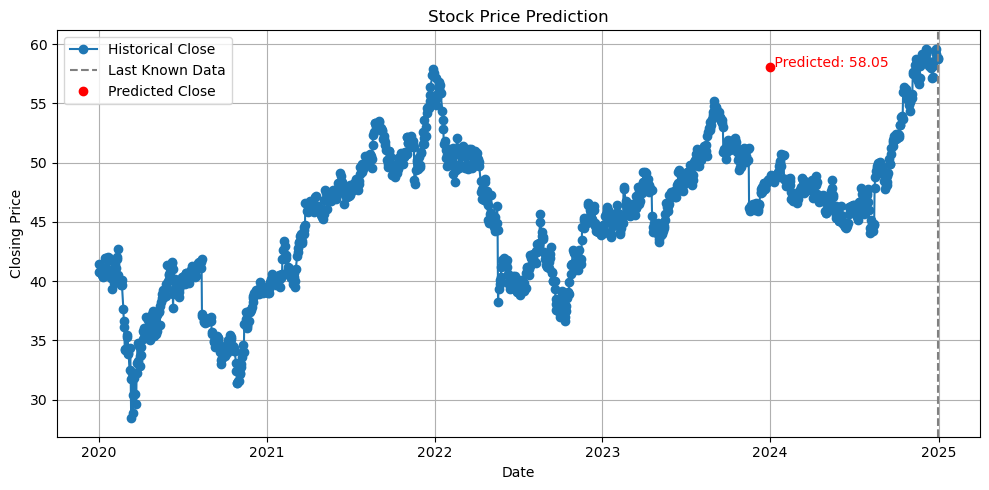

In [ ]:
import mysql.connector
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
import yfinance as yf
from credentials import ipCred, usernameCred, passwordCred, databaseCred
# Database connection configuration
db_config = {
        'host': ipCred,
        'user': usernameCred,
        'password': passwordCred,
        'database': databaseCred
}

def load_model_and_objects(ticker):
    model = load_model(f'{ticker}_lstm_model.h5')
    with open(f'{ticker}_scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)
    with open(f'{ticker}_look_back.pkl', 'rb') as lb_file:
        look_back = pickle.load(lb_file)
    return model, scaler, look_back

def fetch_historical_data(ticker):
    query = f"""
        SELECT Date_ AS date, Close_ AS close
        FROM {ticker}_stock_data
        ORDER BY Date_ ASC;
    """
    conn = mysql.connector.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def iterative_forecast(model, scaler, data, look_back, steps_ahead):
    """
    Predict the closing price for a target date by iteratively forecasting
    one step ahead for 'steps_ahead' days.
    data: Numpy array of scaled closing prices with shape (n,1).
    """
    # Convert last 'look_back' values to a flat list of floats
    forecast_sequence = data[-look_back:, 0].tolist()
    
    for _ in range(steps_ahead):
        X = np.array(forecast_sequence[-look_back:]).reshape(1, look_back, 1)
        scaled_pred = model.predict(X)
        forecast_sequence.append(scaled_pred[0, 0])
    
    predicted_scaled = forecast_sequence[-1]
    predicted_price = scaler.inverse_transform([[predicted_scaled]])[0, 0]
    return predicted_price

def get_actual_price_yfinance(ticker, target_date):
    """
    Use yfinance to get the actual closing price for the given ticker on target_date.
    If yfinance returns no data, return None.
    """
    # Convert datetime to string for yfinance
    target_str = target_date.strftime('%Y-%m-%d')
    next_day_str = (target_date + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Download data from [target_date, target_date+1)
    data = yf.download(ticker, start=target_str, end=next_day_str, progress=False)
    
    if not data.empty and 'Close' in data.columns:
        return data['Close'].iloc[0]
    else:
        return None

def plot_prediction(historical_df, target_date, predicted_price, actual_price=None):
    plt.figure(figsize=(10, 5))
    plt.plot(historical_df['date'], historical_df['close'], label="Historical Close", marker='o')
    
    last_known_date = historical_df['date'].iloc[-1]
    plt.axvline(last_known_date, color='gray', linestyle='--', label="Last Known Data")
    
    # Plot predicted point
    plt.plot(target_date, predicted_price, 'ro', label="Predicted Close")
    plt.text(target_date, predicted_price, f' Predicted: {predicted_price:.2f}', color='red')
    
    # Plot actual close if available
    if actual_price is not None:
        plt.plot(target_date, actual_price, 'go', label="Actual Close")
        plt.text(target_date, actual_price, f' Actual: {actual_price:.2f}', color='green')
    
    plt.title("Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    ticker = input("Enter the ticker symbol (e.g., AAPL, ORCL): ").strip().upper()
    date_str = input("Enter the target date (YYYY-MM-DD): ").strip()
    
    try:
        target_date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")
        return
    
    model, scaler, look_back = load_model_and_objects(ticker)
    historical_df = fetch_historical_data(ticker)
    
    if historical_df.empty:
        print("No historical data found for the ticker.")
        return
    
    last_date = historical_df['date'].iloc[-1]
    
    # Steps ahead from the last known date
    steps_ahead = (target_date - last_date).days
    if steps_ahead < 1:
        # If the requested date is before or equal to the last known date,
        # either we handle it as "already in historical data" or just set steps_ahead=1
        steps_ahead = 1
    
    scaled_data = scaler.transform(historical_df[['close']].values)
    
    # Generate forecast for the target date
    predicted_price = iterative_forecast(model, scaler, scaled_data, look_back, steps_ahead)
    print(f"Predicted closing price for {ticker} on {target_date.strftime('%Y-%m-%d')}: ${predicted_price:.2f}")
    
    # Check if the target date is in the past (relative to today's date)
    today = datetime.today()
    actual_price = None
    
    # If the target date is strictly in the future, we skip retrieving actual data
    if target_date.date() < today.date():
        actual_price = get_actual_price_yfinance(ticker, target_date)
        if actual_price is not None:
            print(f"Actual closing price for {ticker} on {target_date.strftime('%Y-%m-%d')}: ${actual_price:.2f}")
        else:
            # Could be a weekend, holiday, or simply no data
            print(f"No actual data found for {ticker} on {target_date.strftime('%Y-%m-%d')}. "
                  "It might be a non-trading day or delisted ticker.")
    
    plot_prediction(historical_df, target_date, predicted_price, actual_price)

if __name__ == "__main__":
    main()